### Clustering with algoritm Gaussian kernel fuzzy c-means 

This is a implementation with dataset Multiple features in the repository (https://archive.ics.uci.edu/dataset/72/multiple+features)
we apply with tree datasets (mfeat-fac, mfeat-fou, mfeat-kar) for each do it:
  - 50 times, with c=10 for partation fuzzy
  - compute Modified partition coefficient
  - paraments $T = 100, \epsilon=10^{-6}, m = {1.1, 1.3, 1.6}$

  - show the bests with based in fuction cost:
    - prototatipes ${g_{1},..., g_n}$
    - widths ${s_1,..., s_n}$
    - confusion matrix 


base article: Gaussian Kernel Fuzzy C-Means with Width Parameter Computation and Regularization.
PATTERN RECOGNITION, v. 143, p. 109749, 2023, 
doi: https://doi.org/10.1016/j.patcog.2023.109749 

***
Gaussian kernel function
***
$$
  K^{(s_i)}(x_l, x_k) = exp{
    \displaystyle 
    \Bigg \{
      -\frac{1}{2}
      \sum \limits _{j=1}^p 
        \frac{1}{{s^2}_{ij}}
        (x_{lj} - x_{kj})^2
    \Bigg \} 
    }
$$

***
objective  function
***

$$
  J_{KFCM-K-W.2} = 
    \displaystyle 
      \sum \limits _{i=1}^c 
        \sum \limits _{k=1}^n 
          (u_{ki})^m
          (2 - 2{K^{(s_i)}(x_k, g_i)})
$$

$
  s.t. u_{ki} \ge 0
$ and 
$
  \sum \limits _{i=1}^c 
    u_{ki} = 1
$

***
width
***

$$
\frac{1}{s_{ij}} = 
  \frac{
    \Bigg \{
      \prod \limits _{h=1}^p 
        \sum \limits _{k=1}^n 
          {(u_{ki})^m}
          {K^{(s_i)}(x_k, g_i)}
          {(x_{kh} - g_{ih})^2}
    \Bigg \}^
    {
      \frac{1}{p}
    }
  }{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
      {(x_{kj} - g_{ij})^2}
  } 

$$

***
prototipes
***

$$
g_i = 
  \frac{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
      {x_k}

  }{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
  } 
$$
$$
  \forall (1 \le i \le c)
$$

***
fuzzy matrix
***

$$
  u_{ki} = 
    \Bigg [ 
      \sum \limits _{h=1}^c 
        \Bigg ( 
          \frac{
            2 - 2{K^{(s_i)}(x_k, g_i)}
          }{
            2 - 2{K^{(s_i)}(x_k, g_h)}
          }
        \Bigg )^
        {
          \frac{1}{m-1}
        } 
    \Bigg ] ^{-1}
$$

### libs

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# from sklearn.cluster import KMeans


### data x

Para cada dataset < = X
e partição fuzzy < = u, com m [0.5, 0.4, 0.1]
produza uma partição crisp em 10 [1, 0, 0]
grupos e 
calcule o índice de Rand corrigido "adjusted_rand_score"

In [11]:
class Cleaner(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()

  def fit(self, X, y):
    return self
  
  def transform(self, X: pd.DataFrame, y=pd.DataFrame):
    y_lenth = len(y)
    if y_lenth:
      # key = "class"
      # y = pd.DataFrame({key: y})
      values = pd.concat([X, y], axis=1)
    else:
      values = X.copy()

    values = values.dropna()
    values = values.drop_duplicates()
    if y_lenth:
      return values[X.columns.values], values[values.columns.values[-1]]
    return values
  
  def fit_transform(self, X, y=pd.DataFrame):
      return self.fit(X, y).transform(X, y)
  
class Transformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    if type(X) == np.ndarray:
      return X
    return X.values
  def fit_transform(self, X, y=None):
      return self.fit(X, y).transform(X, y)

In [12]:
def load_dataset(filename):
  X = pd.read_csv(filename, header=None, delim_whitespace=True)
  return X 

### metricas

In [85]:
class Gaussian():
  def distance(self, g, x, sigma):
    if x.shape[0] == 0 or sigma.shape[0] == 0:
      raise Exception
    distance = (x - g)**2
    distance_sigma = distance / sigma
    summatory_distance = (-1/2)*np.sum(distance_sigma, 1)
    return np.exp(summatory_distance)

class Metrics():
  def mpc(u: np.array):
    # modified partition coefficient
    n, k = u.shape
    f = np.trace(u.dot(u.T)) / n
    # f = np.trace(u**2) / n

    mpc = 1 - (k/(k - 1))*(1 - f)
    return mpc
  def ars(y_true, y_pred):
    return adjusted_rand_score(y_true, y_pred)

### new model

In [14]:
# n = numero total de X
# k = numero de prototipos
# remover a constante das distancias
# qual s é muito pequeno que fica proximo de 0
# usar o maximo possivel a bibiloteca(numpy) para o j, removendo os FORs 

In [15]:
p = 3
ss = np.array([0.000398, 0.0000038, 0.000067])
ss = np.array([1e-7, 7e-9, 3e-5])
# ss = np.array([0.01, 0.1, 0.5])
m = np.sum(ss)/p
# n = ss/m
n = (1 - ss) **(1/(p))
d = np.prod(n)
dd = (d)**(1/p)
sss = dd/n
sss, np.prod(sss)
# (array([0.99999006, 0.99998997, 1.00001996]), 1.0000000000000002)
# (array([0.99999669, 0.99999666, 1.00000665]), 1.0000000000000004)

(array([0.99999669, 0.99999666, 1.00000665]), 1.0000000000000004)

In [82]:
# tá funcionando bonitinho
class Shower():
  def __init__(self) -> None:
    pass
  def show_grafico(self, x):
    _, axes = plt.subplots()
    markers = ['^','x','+']
    p = self.predict(self.G, x)
    
    for (c, (x_1, x_2)) in zip(p, x):
      r, g, b, a = .9*((c+1)/self.num_class), .9*((c*1.1)/self.num_class), .9*((c*1.2)/self.num_class), 0.1
      
      axes.plot(x_1, x_2, "ro", marker=markers[c])
      # if c:
      # # axes.plot(x_1, x_2, c = (r, g, b, a))
      # else:
      #     axes.plot(x_1, x_2, "bo")
        
    raio = self.distance_classes() / 2
    
    for i, (x_1, x_2) in enumerate(self.G):
        
        plt.plot(x_1, x_2, "go", scalex=0.01,scaley=0.01)
        # r, g, b, a = .9*((i+1)/self.num_class), .1*((i+1)/self.num_class), .1*(self.num_class/(i+1)), 0.9
        r, g, b, a = .9*((i+1)/self.num_class), .9*((i*1.1)/self.num_class), .9*((i*1.2)/self.num_class), 0.9
        # print(r, g, b, a)
        c = plt.Circle((x_1, x_2), raio, color=(r, g, b, a), fill=False)

        axes.set_aspect(aspect = 1, adjustable = "datalim", anchor="SW")
        axes.add_artist(c)
    plt.show()
  
  def show_labels(self, x):
    _, axes = plt.subplots()
    axes.imshow(x)

    plt.show()
  
  def show_G_S_U(self):
    # print(np.sum(self.G, 1))
    # print(np.sum(self.U, 1))
    print("Gs")
    self.show_labels(self.G)
    print("S2s")
    self.show_labels(self.sigma)
    print("Us")
    for i in range(0, 100, 80):
      self.show_labels((self.U[i:i + 80]).T)

class FuzzyCMeansGaussianS2(Shower):
  def __init__(self, num_class, epochs, threshold, loss = Gaussian(), m=1.1, seeder=0, verbose = False) -> None:
    # load the hiperparams
    self.num_class = num_class
    self.loss = loss    
    self.var_type = np.double
    # self.var_type = np.float
    self.m = m 
    self.verbose = verbose
    self._only = True
    if seeder:
      self.seeder = seeder
      np.random.seed(seeder)
      
    self.threshold = threshold
    self.epochs = epochs 

  def predict(self, x):
    # here we make predict in x
    n = x.shape[0] 

    predict_value = np.zeros((n, self.k), dtype=self.var_type)

    for i in range(self.k):
      predict_value[:,i] = self.loss.distance(self.G[i], x, self.sigma[i])
    return predict_value.argmax(1)
  
  def init_g(self, x):
    # here we get random prototipes to train
    args = np.random.choice(x.shape[0], self.num_class, replace=False)
    self.G = x[args].copy()

  def init_u(self, x):
    # we calcule initial matrix of membership
    g = self.G.copy()
    sigma = self.sigma.copy()
    self.n = x.shape[0]
    self.k = g.shape[0]
    
    self.U = np.zeros((self.n, self.k), self.var_type)

    distances = np.array([2 - 2*self.loss.distance(g[i], x, sigma[i]) for i in range(self.k)]).T

    expoente = 1/(self.m-1)

    for i in range(self.n):
      # summation_c = np.array([(distances[i, h] / distances[i])**expoente for h in range(self.k)]) 
      # np.divide
      summation_c = np.array([(distances[i] / distances[i, h])**expoente for h in range(self.k)]) #.T 
      # summation_c = np.array([np.divide(distances[i], distances[i, h], where=distances[i, h]!=0)**expoente for h in range(self.k)]).T 

      summation_c_i = np.sum(summation_c, 0)
      summation_c_i = np.power(summation_c_i, -1)

      membership_is_nan = np.isnan(summation_c_i)
      
      summation_u = np.sum(summation_c_i, where=membership_is_nan==False)

      summation_u_1 = 1 - summation_u
      abs_summation_u_1 = np.abs(summation_u_1)

      if summation_u == 0 or membership_is_nan.any():
          count = np.sum(membership_is_nan) # total nan
          self.U[i] = np.nan_to_num(summation_c_i, nan = summation_u_1/count)   
      elif abs_summation_u_1 > .01:
        arg = summation_c_i.argmax()
        summation_c_i[arg] = summation_c_i[arg] + summation_u_1
        
        self.U[i] = summation_c_i.copy()
      else:
        self.U[i] = summation_c_i.copy()

    # self.U = u.copy()   
   
  def init_sigma(self, x):
    # we calcule initial matrix of widths each 1
    self.p = x.shape[1]
    self.k = self.G.shape[0]
    self.sigma = np.ones((self.k, self.p), dtype=self.var_type)

  # passo 1
  def otm_prototivo(self, g, u, x, sigma):
    new_g = g.copy()
    u_i = u**self.m

    for i in range(self.k):
      n_g = self.loss.distance(g[i], x, sigma[i])
      
      u_m_g = (u_i[:,i]*n_g)#*
      u_m_gx = ((x.T)*u_m_g).T

      s_umg = np.sum(u_m_g)
      s_umgx = np.sum(u_m_gx, 0)
      
      new_g[i] = s_umgx / s_umg 
    return new_g
  
  # passo 2
  def otm_u(self, g, x, sigma):
    new_u = np.zeros((self.n, self.k), dtype=self.var_type)  
    
    distances = np.array([2 - 2*self.loss.distance(g[i], x, sigma[i]) for i in range(self.k)]).T
    
    expoente = 1/(self.m-1)
    for i in range(self.n):
      
      summation_c = np.array([(distances[i] / distances[i, h])**expoente for h in range(self.k)]) 

      summation_c_i = np.sum(summation_c, 0)
      summation_c_i = np.power(summation_c_i, -1)

      membership_is_nan = np.isnan(summation_c_i)
      
      summation_u = np.sum(summation_c_i, where=membership_is_nan==False)
      
      summation_u_1 = 1 - summation_u
      abs_summation_u_1 = np.abs(summation_u_1)

      if summation_u == 0 or membership_is_nan.any():
          count = np.sum(membership_is_nan) # total nan
          new_u[i] = np.nan_to_num(summation_c_i, nan = summation_u_1/count)     
      elif abs_summation_u_1 > .01:
          arg = summation_c_i.argmax()
          summation_c_i[arg] = summation_c_i[arg] + summation_u_1
          
          new_u[i] = summation_c_i.copy()
      else:
        new_u[i] = summation_c_i.copy()
    return new_u

  def otm_sigma(self, x, g, u):
    s = self.sigma.copy()
    
    ui = (u**(self.m))
    
    for i in range(self.k):
      g_i = g[i]
      ui_per = ui[:,i]
      

      g_d = self.loss.distance(g_i, x, s[i]) 
      e_d = (x - g_i)**2 
      
      s_cn = e_d.T*(ui_per*g_d)
      
      if s_cn.shape[1] != 1:
        ss_cn = np.sum(s_cn, 1).copy()
      else:
        ss_cn = np.squeeze(s_cn, 1).copy()
        

      s_p = np.prod(ss_cn)
      s_p = s_p**(1/self.p)
      
      s_ij = s_p / ss_cn 

      r_r = s_ij[np.isnan(s_ij) == False]
      p_r = np.prod(r_r)
      
      s_r = np.abs(1 - p_r)
      
              
      # verificacao do produtorio para a classe que deve ser 1
      if p_r == 0: 
        # quando os Si forem muito pequeno o produtorio dá zero por causa computacional
        # sendo assim eu redistubuo a partir do inverso da media
        # ss_cn => todos denominadores de Si
        # [1/2, 1/2, 1/2] = [0.1/0.2 0.1/0.2 0.1/0.2] 

        # [S_i1, S_i2, S_i3] = [0.000398*0.0000038*0.000067/0.000398 
        #                       0.000398*0.0000038*0.000067/0.0000038 
        #                       0.000398*0.0000038*0.000067/0.000067]
        #  [S_i1, S_i2, S_i3] = [2.5460e-10, 2.6666e-08, 1.5124e-09]

        # -1 aqui faco a media dos denominadores dos si 
        # que no caso o resultado dos somatorios 
        teste = False

        if teste:
          m_s = np.sum(ss_cn)/(self.p) 
        # m_s = sum([0.2 0.2 0.2])/2

        # p
        # m_s = sum([0.000398 0.0000038 0.000067])/3
        # m_s = 0.00015626666666666668
        # p - 1
        # m_s = sum([0.000398 0.0000038 0.000067])/2
        # m_s = 0.0002344



        # ss_cn = ss_cn*(1/m_s)
        if teste:
          im_s = 1/(m_s)
          new_ss_cn = ss_cn*im_s
        else:
          new_ss_cn = (1 - ss_cn) #**(1/(self.p))
        # new_ss_cn = [0.0033 0.0033 0.0033]/0.2


        # p
        # new_ss_cn = [0.000398 0.0000038 0.000067]/0.00015626666666666668
        # new_ss_cn = [2.54692833 0.02431741 0.42875427]

        # p - 1
        # new_ss_cn = [0.000398 0.0000038 0.000067]/0.0002344
        # new_ss_cn = [1.69795222 0.0162116 0.28583618]

        new_s_p = np.prod(new_ss_cn)
        # p
        # prod(new_ss_cn) = 0.0265547628046677

        # p -1
        # prod(new_ss_cn) = 0.00786807786804969


        new_s_p = new_s_p**(1/self.p)
        # p
        # new_s_p = 0.29834182508986407

        # p -1
        # new_s_p = 0.08870218637694163

        
        new_r = new_s_p / new_ss_cn 

        # p
        # new_r = 0.0265547628046677/[2.54692833 0.02431741 0.42875427]
        # new_r = [0.1171379 , 12.2686533 ,  0.69583407]
        # prod(new_ss_cn) = 0.75

        # p -1
        # new_r = 0.4898979485566356/[1.69795222 0.0162116 0.28583618]
        # new_r = [0.05224068, 5.47152434, 0.31032526 ]

        prod = np.prod(new_r)
        # p
        # prod = 1
        # p -1
        # prod = 0.0887021863769416

        if np.isnan(prod)==False:
          s[i] = new_r.copy()
        
      elif s_r > .1:
        # para quando o produtorio de Ss dá diferente de 1 
        if r_r.shape[0] == s_ij.shape[0]:
          s[i] = s_ij/(p_r**(1/s_ij.shape[0]))
        else:
          s_prod = (1/(p_r**(1/s_ij.shape[0])))
          s[i] = np.nan_to_num(s_ij, copy=True, nan=s_prod)
      else:
        s[i] = s_ij.copy()
          
    return s

  def funcao_objetivo(self, x, g, u, sigma):
    # k = g.shape[0]
    u_i = u**self.m
    f = np.zeros(self.k, dtype=self.var_type)
    
    s_d = np.zeros(x.shape[0], dtype=self.var_type)
    w = np.zeros(x.shape[0], dtype=self.var_type)
    for i in range(self.k):
      s_d = 2 - 2*self.loss.distance(g[i], x, sigma[i])
      
      w = s_d.T*(u_i[:, i])
      f[i] = np.sum(w)
      
    return np.sum(f)

  def atualiza_GUS2(self, g, u, sigma):
    self.G = g
    self.U = u
    self.sigma = sigma

  def modified_partition_coefficient(self):
    n, k = self.U.shape
    # f = np.trace(self.U.dot(self.U.T)) / n

    f = np.trace(self.U**2) / n

    mpc = 1 - (k/(k - 1))*(1 - f)

    return mpc

  def fit(self, x, y, verbose = False):
    self.redu = True
    
    self.init_g(x)
    self.init_sigma(x)
    self.init_u(x)

    j = self.funcao_objetivo(x, self.G, self.U, self.sigma) 
    if self._only:
      print("epoca:", 0, "funcão objetivo:", j) #, new_f

    
    for epoch in range(self.epochs):
      # print("passo 1")
      new_sigma = self.otm_sigma(x, self.G, self.U)

      # print("passo 2")
      new_g = self.otm_prototivo(self.G, self.U, x, new_sigma)

      # print("passo 3")
      new_u = self.otm_u(new_g, x, new_sigma)

      new_j = self.funcao_objetivo(x, new_g, new_u, new_sigma)
      if self._only:
        print(f"epoca: {epoch + 1} funcão objetivo: {new_j}")# f,
        # print(f"Modified partition coefficient  {self.modified_partition_coefficient()},  {adjusted_rand_score(y, self.U.argmax(1))}")# f,
        print(f"Modified partition coefficient  {Metrics.mpc(self.U)},  {Metrics.ars(y, self.U.argmax(1))}")# f,
      
      # silhouette_score
      if verbose:
        self.show_grafico(x)
      
      dif = np.abs(new_j - j)
      # new_j > j
      if (np.isnan(new_j)==True or dif < self.threshold):
        return
      else:
        j = new_j
        self.atualiza_GUS2(new_g, new_u, new_sigma)

class Trainer(Shower):
  def __init__(self, num_class, epochs, threshold, model_creator, loss = Gaussian(), m = 1.1, verbose = False, repeat = 1) -> None:
    # load the hiperparams
    self.num_class = num_class
    self.loss = loss    
    self.var_type = np.double
    # self.var_type = np.float
    self.m = m 
    self.verbose = verbose      
    self.threshold = threshold
    self.epochs = epochs 
    self.repeat = repeat
    self.model_creator = model_creator
  
  def predict(self, x):
    # here we make predict in x
    n = x.shape[0] 
    k = self.G.shape[0] 

    predict_value = np.zeros((n, k), dtype=self.var_type)

    for i in range(k):
      predict_value[:,i] = self.loss.distance(self.G[i], x, self.sigma[i])
    return predict_value.argmax(1)

    
  def fit(self, X, y):
    j = np.inf
    
    for i in range(self.repeat):
      model = self.model_creator(num_class=self.num_class, epochs=self.epochs, threshold=self.threshold, loss=self.loss, m=self.m, verbose=self.verbose)
      model._only = False
      model.fit(X, y)
      new_j = model.funcao_objetivo(X, model.G, model.U, model.sigma)
      print(f"repeation: {i + 1} funcão objetivo: {new_j}")
      print(f"Modified partition coefficient: {Metrics.mpc(model.U)},  adjusted_rand_score: {Metrics.ars(y, model.U.argmax(1))}")

      if new_j < j:
        self.G = model.G
        self.U = model.U
        self.sigma = model.sigma
        j = new_j


## fit the model with datasets

### datasets -> mfeat-fac

In [ ]:
X = load_dataset("datasets\mfeat-fac", 1)
# MinMaxScaler
# minmax_scale
# MaxAbsScaler
# StandardScaler
# RobustScaler
# Normalizer
# QuantileTransformer

y = pd.DataFrame({X.shape[1]: np.arange(0, X.shape[0])//200})
X_clean, y_clean = Cleaner().transform(X, y)

# model = FuzzyCMeansGaussianS2(num_class=10, epochs = 50, m=1.1, verbose=False, threshold=1e-6) # 
model = Trainer(num_class = 10, epochs = 100, threshold = 1e-6, model_creator=FuzzyCMeansGaussianS2, m = 1.1, verbose = False, repeat = 50)

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

Gs


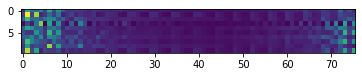

S2s


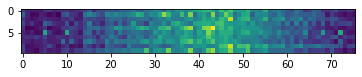

Us


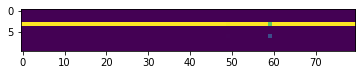

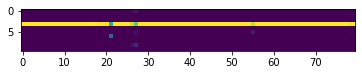

In [52]:
model.show_G_S_U()

In [53]:
y_predict = pipeline.predict(X_clean) #(2000) <= (2000, 200)
cm = confusion_matrix(y_clean, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

AttributeError: 'Trainer' object has no attribute 'predict'

### datasets -> mfeat-fou

c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 1 funcão objetivo: 374.7210036901952
Modified partition coefficient: 0.8078972289981123,  adjusted_rand_score: 0.39095140837587217


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 2 funcão objetivo: 344.21890448690516
Modified partition coefficient: 0.8727359011018607,  adjusted_rand_score: 0.3993127279623902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 3 funcão objetivo: 344.05194818376526
Modified partition coefficient: 0.8538287145824986,  adjusted_rand_score: 0.4180438899178823


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 4 funcão objetivo: 334.74131383508495
Modified partition coefficient: 0.8734628587489407,  adjusted_rand_score: 0.4149872169345159


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 5 funcão objetivo: 333.64494767186727
Modified partition coefficient: 0.8348349041250683,  adjusted_rand_score: 0.44493871959997233


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 6 funcão objetivo: 344.1554384366967
Modified partition coefficient: 0.8740496009630991,  adjusted_rand_score: 0.4300620957925806


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 7 funcão objetivo: 331.9492913808657
Modified partition coefficient: 0.818119993480543,  adjusted_rand_score: 0.43523774437794766


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 8 funcão objetivo: 353.6382498631733
Modified partition coefficient: 0.8726291438840408,  adjusted_rand_score: 0.38410920132226095


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 9 funcão objetivo: 336.05386212448906
Modified partition coefficient: 0.8500982773356891,  adjusted_rand_score: 0.423010478098727


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 10 funcão objetivo: 338.84190059103645
Modified partition coefficient: 0.8387306251986537,  adjusted_rand_score: 0.42324184054267006


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 11 funcão objetivo: 333.6334259845789
Modified partition coefficient: 0.8347992938497315,  adjusted_rand_score: 0.44493871959997233


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 12 funcão objetivo: 332.4127388488843
Modified partition coefficient: 0.8483203290419977,  adjusted_rand_score: 0.46343633435703246


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 13 funcão objetivo: 330.27931265472193
Modified partition coefficient: 0.8520963245947758,  adjusted_rand_score: 0.4573485548671982


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 14 funcão objetivo: 350.47765233027707
Modified partition coefficient: 0.8459176364613121,  adjusted_rand_score: 0.36898155937617505


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 15 funcão objetivo: 334.5862405946619
Modified partition coefficient: 0.8618162364408579,  adjusted_rand_score: 0.44438451409624563


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 16 funcão objetivo: 339.4206942924823
Modified partition coefficient: 0.8496310334772639,  adjusted_rand_score: 0.4451487161101224


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 17 funcão objetivo: 332.4127359681053
Modified partition coefficient: 0.8483205221848681,  adjusted_rand_score: 0.46343633435703246


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 18 funcão objetivo: 340.13574023969863
Modified partition coefficient: 0.8693603550908267,  adjusted_rand_score: 0.46445159614450654


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 19 funcão objetivo: 332.7034677472752
Modified partition coefficient: 0.843188529660033,  adjusted_rand_score: 0.4581021198063122


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 20 funcão objetivo: 349.44761958726804
Modified partition coefficient: 0.8389167630832064,  adjusted_rand_score: 0.35276365240371577


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 21 funcão objetivo: 343.8610062181705
Modified partition coefficient: 0.8576001322693033,  adjusted_rand_score: 0.4187683984688716


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 22 funcão objetivo: 330.208507334494
Modified partition coefficient: 0.8517959144268159,  adjusted_rand_score: 0.45770683037633425


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 23 funcão objetivo: 365.35330818587147
Modified partition coefficient: 0.7569923318555788,  adjusted_rand_score: 0.35018023527755876


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 24 funcão objetivo: 358.54024257174575
Modified partition coefficient: 0.8508885859596166,  adjusted_rand_score: 0.40350074921891427


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 25 funcão objetivo: 334.68368397074966
Modified partition coefficient: 0.8614582816163838,  adjusted_rand_score: 0.44370936825356666


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 26 funcão objetivo: 332.3932998999521
Modified partition coefficient: 0.8486182295132791,  adjusted_rand_score: 0.4629506528735495


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 27 funcão objetivo: 336.0538864824217
Modified partition coefficient: 0.8500983020700348,  adjusted_rand_score: 0.423010478098727


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 28 funcão objetivo: 354.5094788288169
Modified partition coefficient: 0.865615639533722,  adjusted_rand_score: 0.38438716983158233


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 29 funcão objetivo: 329.8065901413175
Modified partition coefficient: 0.8567611468623976,  adjusted_rand_score: 0.4593691573080957


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 30 funcão objetivo: 344.9434870122552
Modified partition coefficient: 0.8677273019156599,  adjusted_rand_score: 0.3992326605578813


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 31 funcão objetivo: 354.38678507394786
Modified partition coefficient: 0.8661655345276893,  adjusted_rand_score: 0.38328366824894217


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 32 funcão objetivo: 343.01995328451125
Modified partition coefficient: 0.849385977589644,  adjusted_rand_score: 0.39296866995927765


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 33 funcão objetivo: 341.4978805039499
Modified partition coefficient: 0.8641039828723199,  adjusted_rand_score: 0.44214328654801405


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 34 funcão objetivo: 342.96256817778925
Modified partition coefficient: 0.8494322028587533,  adjusted_rand_score: 0.3918663332392636


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 35 funcão objetivo: 344.27225312448184
Modified partition coefficient: 0.850633724419806,  adjusted_rand_score: 0.4256734817977464


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 36 funcão objetivo: 369.9746189126731
Modified partition coefficient: 0.7872317094123202,  adjusted_rand_score: 0.34040900709462824


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 37 funcão objetivo: 340.20533315915725
Modified partition coefficient: 0.8321101677957015,  adjusted_rand_score: 0.4085148842632008


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 38 funcão objetivo: 332.412740233444
Modified partition coefficient: 0.8483202279096047,  adjusted_rand_score: 0.46343633435703246


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 39 funcão objetivo: 336.05433192613805
Modified partition coefficient: 0.850098584817168,  adjusted_rand_score: 0.423010478098727


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 40 funcão objetivo: 334.9618507416836
Modified partition coefficient: 0.8600041513475948,  adjusted_rand_score: 0.44567865334438433


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 41 funcão objetivo: 343.92352331998615
Modified partition coefficient: 0.8467610377121607,  adjusted_rand_score: 0.42189322905998655


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 42 funcão objetivo: 384.33255895729485
Modified partition coefficient: 0.853638993372652,  adjusted_rand_score: 0.2791271709010377


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 43 funcão objetivo: 334.46659692943706
Modified partition coefficient: 0.8545835860691762,  adjusted_rand_score: 0.45271770409837614


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 44 funcão objetivo: 333.27285110820003
Modified partition coefficient: 0.8538450936977893,  adjusted_rand_score: 0.4587246452322728


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 45 funcão objetivo: 333.2643020164806
Modified partition coefficient: 0.8538626480784086,  adjusted_rand_score: 0.4587246452322728


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 46 funcão objetivo: 335.9896050367552
Modified partition coefficient: 0.8522072282534988,  adjusted_rand_score: 0.423010478098727


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 47 funcão objetivo: 330.5917938169473
Modified partition coefficient: 0.8374744797506852,  adjusted_rand_score: 0.4140029875112006


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 48 funcão objetivo: 342.12627020425896
Modified partition coefficient: 0.8604689870125459,  adjusted_rand_score: 0.4403317127356443


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 49 funcão objetivo: 333.0670273389396
Modified partition coefficient: 0.8582069256137174,  adjusted_rand_score: 0.45656139268985624


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


repeation: 50 funcão objetivo: 330.4227682709443
Modified partition coefficient: 0.8547282368187579,  adjusted_rand_score: 0.4345123968575293
Gs


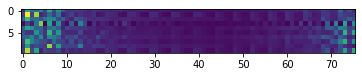

S2s


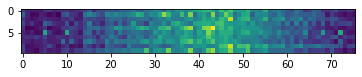

Us


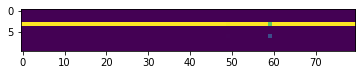

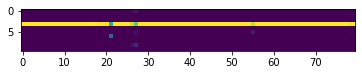

(array([[0.07536744, 0.30909558, 0.20030676, 0.19018011, 0.24446924,
         0.1322566 , 0.30506947, 0.1407953 , 0.26254569, 0.16243664,
         0.1091474 , 0.10098652, 0.11338601, 0.10472586, 0.10228613,
         0.08066156, 0.09820331, 0.08758115, 0.08339873, 0.08582089,
         0.07968154, 0.08066153, 0.08571335, 0.07082135, 0.07262177,
         0.07064426, 0.0742431 , 0.07356849, 0.06667456, 0.06234032,
         0.06377035, 0.06590104, 0.06701406, 0.065003  , 0.05884699,
         0.05978198, 0.06334939, 0.05948667, 0.05922267, 0.0567678 ,
         0.05522451, 0.0558229 , 0.0561554 , 0.05652112, 0.05586793,
         0.0524272 , 0.05489626, 0.05332761, 0.0573654 , 0.05888201,
         0.05979484, 0.05913952, 0.06514754, 0.06137239, 0.06355828,
         0.0635712 , 0.07279241, 0.0648883 , 0.06797783, 0.07104164,
         0.08396378, 0.07490033, 0.07944263, 0.07122002, 0.10828354,
         0.08148235, 0.07553044, 0.08162363, 0.11124606, 0.0982389 ,
         0.08300986, 0.08680741, 0

In [47]:
X = load_dataset("datasets\mfeat-fou")

y = pd.DataFrame({X.shape[1]: np.arange(0, X.shape[0])//200})
X_clean, y_clean = Cleaner().transform(X, y)

# model = FuzzyCMeansGaussianS2(num_class=10, epochs = 50, m=1.01, verbose=False, threshold=1e-6) # 
model = Trainer(num_class = 10, epochs = 100, threshold = 1e-6, model_creator=FuzzyCMeansGaussianS2, m = 1.1, verbose = False, repeat = 50)
pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)
# model.fit(X, 30)
model.show_G_S_U()
model.G, model.U, model.sigma

In [50]:
y_predict = pipeline.predict(X_clean) #(2000) <= (2000, 200)
cm = confusion_matrix(y_clean, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

AttributeError: 'Trainer' object has no attribute 'predict'

### datasets -> mfeat-kar

In [44]:
X = load_dataset("datasets\mfeat-kar")
# m com melhor resultados, 1.02


y = pd.DataFrame({X.shape[1]: np.arange(0, X.shape[0])//200})
X_clean, y_clean = Cleaner().transform(X, y)

# model = FuzzyCMeansGaussianS2(num_class=10, epochs = 50, m=1.01, verbose=True, threshold=1e-6) # 
model = Trainer(num_class = 10, epochs = 100, threshold = 1e-6, model_creator=FuzzyCMeansGaussianS2, m = 1.1, verbose = False, repeat = 50)
pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 1 funcão objetivo: 1877.2199730450484
Modified partition coefficient: 0.6881532340292134,  adjusted_rand_score: 0.3777663617980707


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 2 funcão objetivo: 1876.4271379222605
Modified partition coefficient: 0.6671954174227847,  adjusted_rand_score: 0.48334957932857403


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 3 funcão objetivo: 1806.2510704636763
Modified partition coefficient: 0.7103962753667771,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 4 funcão objetivo: 1806.2470607907899
Modified partition coefficient: 0.7103941239696494,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 5 funcão objetivo: 1806.25259346121
Modified partition coefficient: 0.7103970385091438,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 6 funcão objetivo: 1835.79297859175
Modified partition coefficient: 0.7036255890330516,  adjusted_rand_score: 0.5845361122334449


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 7 funcão objetivo: 1817.4062939950165
Modified partition coefficient: 0.706210846980659,  adjusted_rand_score: 0.48316300208618757


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 8 funcão objetivo: 1843.691258472888
Modified partition coefficient: 0.6871725385689109,  adjusted_rand_score: 0.46128388831573014


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 9 funcão objetivo: 1819.0039412013327
Modified partition coefficient: 0.7038401035041271,  adjusted_rand_score: 0.502473334397098


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 10 funcão objetivo: 1819.0033265670033
Modified partition coefficient: 0.70384047891734,  adjusted_rand_score: 0.502473334397098


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 11 funcão objetivo: 1806.2505130630982
Modified partition coefficient: 0.7103959903096053,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 12 funcão objetivo: 1841.901478470462
Modified partition coefficient: 0.7022401828796214,  adjusted_rand_score: 0.5722257277282541


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 13 funcão objetivo: 1820.546835263283
Modified partition coefficient: 0.7137316375176129,  adjusted_rand_score: 0.4552521631023444


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 14 funcão objetivo: 1806.2514716196456
Modified partition coefficient: 0.7103964792652243,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 15 funcão objetivo: 1848.8083274061723
Modified partition coefficient: 0.679893898884202,  adjusted_rand_score: 0.5238196244080926


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 16 funcão objetivo: 1841.1663600780348
Modified partition coefficient: 0.6985848186042094,  adjusted_rand_score: 0.5098610383746703


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 17 funcão objetivo: 1840.74899819897
Modified partition coefficient: 0.685447574575259,  adjusted_rand_score: 0.5059806337679922


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 18 funcão objetivo: 1806.2543709776137
Modified partition coefficient: 0.7103979173757011,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 19 funcão objetivo: 1799.6234137771303
Modified partition coefficient: 0.721162347100599,  adjusted_rand_score: 0.49616315876723455


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 20 funcão objetivo: 1806.25118933437
Modified partition coefficient: 0.7103963374253721,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 21 funcão objetivo: 1848.778583871711
Modified partition coefficient: 0.705955575210277,  adjusted_rand_score: 0.4918401199567022


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 22 funcão objetivo: 1799.6126125785722
Modified partition coefficient: 0.7211445590485471,  adjusted_rand_score: 0.49616315876723455


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 23 funcão objetivo: 1869.5067250387726
Modified partition coefficient: 0.6767314116693932,  adjusted_rand_score: 0.4349357469120506


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 24 funcão objetivo: 1879.9185764697497
Modified partition coefficient: 0.6661922190719158,  adjusted_rand_score: 0.5311579235353094


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 25 funcão objetivo: 1799.623479663938
Modified partition coefficient: 0.721164855122182,  adjusted_rand_score: 0.49616315876723455


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 26 funcão objetivo: 1826.0401785644267
Modified partition coefficient: 0.7123579662491635,  adjusted_rand_score: 0.4297768359290442


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 27 funcão objetivo: 1811.0438839366143
Modified partition coefficient: 0.7091003165510243,  adjusted_rand_score: 0.4996331746448997


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 28 funcão objetivo: 1835.7928183821864
Modified partition coefficient: 0.7036257817053779,  adjusted_rand_score: 0.5845361122334449


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 29 funcão objetivo: 1806.251492221485
Modified partition coefficient: 0.710396492560303,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 30 funcão objetivo: 1799.623490607231
Modified partition coefficient: 0.7211652844860104,  adjusted_rand_score: 0.49616315876723455


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 31 funcão objetivo: 1826.0401782298181
Modified partition coefficient: 0.712357965886526,  adjusted_rand_score: 0.4297768359290442


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 32 funcão objetivo: 1830.5577726691342
Modified partition coefficient: 0.7148757391486362,  adjusted_rand_score: 0.4948411055230334


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 33 funcão objetivo: 1806.2526138473293
Modified partition coefficient: 0.7103970484133759,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 34 funcão objetivo: 1829.14708375584
Modified partition coefficient: 0.6963495820006774,  adjusted_rand_score: 0.5102073506798266


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 35 funcão objetivo: 1806.251525431621
Modified partition coefficient: 0.710396506102132,  adjusted_rand_score: 0.5762327398932902


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 36 funcão objetivo: 1799.6234629874482
Modified partition coefficient: 0.7211674330583187,  adjusted_rand_score: 0.49616315876723455


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 37 funcão objetivo: 1799.6234693235917
Modified partition coefficient: 0.7211637160945295,  adjusted_rand_score: 0.49616315876723455


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 38 funcão objetivo: 1841.9030592214058
Modified partition coefficient: 0.702240263564441,  adjusted_rand_score: 0.5722257277282541


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 39 funcão objetivo: 1880.0539352292872
Modified partition coefficient: 0.6657871610523548,  adjusted_rand_score: 0.5304594480188558


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 40 funcão objetivo: 1840.8149056531017
Modified partition coefficient: 0.699911016102928,  adjusted_rand_score: 0.424114301845494


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 41 funcão objetivo: 1835.79255905417
Modified partition coefficient: 0.7036262710977093,  adjusted_rand_score: 0.5845361122334449


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 42 funcão objetivo: 1841.1663500498987
Modified partition coefficient: 0.6985848561362782,  adjusted_rand_score: 0.5098610383746703


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 43 funcão objetivo: 1854.0391667912215
Modified partition coefficient: 0.6922517484663004,  adjusted_rand_score: 0.42041767773092714


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 44 funcão objetivo: 1877.3800704081352
Modified partition coefficient: 0.7057961713111405,  adjusted_rand_score: 0.48502871779478995


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 45 funcão objetivo: 1799.6075864334807
Modified partition coefficient: 0.7211362102127443,  adjusted_rand_score: 0.4965249429070202


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 46 funcão objetivo: 1824.2907821817362
Modified partition coefficient: 0.7186064591699931,  adjusted_rand_score: 0.5704537377556418


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 47 funcão objetivo: 1829.3183209885149
Modified partition coefficient: 0.6962842876582348,  adjusted_rand_score: 0.5103322691544591


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 48 funcão objetivo: 1820.54665545276
Modified partition coefficient: 0.7137307880464459,  adjusted_rand_score: 0.4552521631023444


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 49 funcão objetivo: 1849.5991686655584
Modified partition coefficient: 0.7036985853087916,  adjusted_rand_score: 0.49845757611455865


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


repeation: 50 funcão objetivo: 1806.2516155336211
Modified partition coefficient: 0.7103965513513126,  adjusted_rand_score: 0.5762327398932902


AttributeError: 'Trainer' object has no attribute 'show_G_S_U'

In [ ]:
model.show_G_S_U()

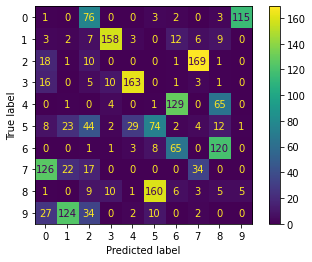

In [57]:
y_predict = pipeline.predict(X_clean)

cm = confusion_matrix(y_clean, y_predict)
# model.show_labels(m)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

### datasets -> combo

In [130]:
X_1 = load_dataset("datasets\mfeat-fac", 1)
X_2 = load_dataset("datasets\mfeat-fou", 1)
X_3 = load_dataset("datasets\mfeat-kar", 1)
X = pd.concat([X_1, X_2, X_3], axis=1)
# print(X.shape)
# raise Exception

y = pd.DataFrame({X.shape[1]: np.arange(0, X.shape[0])//200})
X_clean, y_clean = Cleaner().transform(X, y)

model = FuzzyCMeansGaussianS2(num_class=10, epochs = 50, m=1.1, verbose=False, threshold=1e-6) # 
pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)
# model.fit(X, 30)
model.show_G_S_U()
model.G, model.U, model.sigma


TypeError: load_dataset() takes 1 positional argument but 2 were given

### datasets -> iris

In [86]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
y = pd.DataFrame({len(X.columns.values):iris.target})
X_clean, y_clean = Cleaner().transform(X, y)

# model = FuzzyCMeansGaussianS2(num_class=3, epochs = 50, m=1.1, verbose=False, threshold=1e-6) # 
model = Trainer(num_class = 3, epochs = 100, threshold = 1e-6, model_creator=FuzzyCMeansGaussianS2, m = 1.1, verbose = False, repeat = 50)

pipeline = Pipeline([("Normalizer", Normalizer(copy=True)), 
                     ("Transformer", Transformer()),                      
                    ("Model", model),
                    ])

pipeline.fit(X_clean, y_clean)

# model.fit(X, 30)
# model.G, model.U, model.sigma

c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 1 funcão objetivo: 0.40578031598746966
Modified partition coefficient: 0.9869918527598074,  adjusted_rand_score: 0.9035691663683182
repeation: 2 funcão objetivo: 0.40578067939057527


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.986991881317662,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 3 funcão objetivo: 0.579858869174374
Modified partition coefficient: 0.9999181000037687,  adjusted_rand_score: 0.5511952620159147


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 4 funcão objetivo: 0.4057802841384216
Modified partition coefficient: 0.9869918463377942,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 5 funcão objetivo: 0.40578027841344666
Modified partition coefficient: 0.9869918452945508,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 6 funcão objetivo: 0.4057802636943343
Modified partition coefficient: 0.9869918425047841,  adjusted_rand_score: 0.9035691663683182
repeation: 7 funcão objetivo: 0.4057794209037148
Modified partition coefficient: 0.9869916793172797,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 8 funcão objetivo: 0.4057796120596713
Modified partition coefficient: 0.9869917121666936,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 9 funcão objetivo: 0.4057804925724434
Modified partition coefficient: 0.9869918873771989,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 10 funcão objetivo: 0.40578026437378956
Modified partition coefficient: 0.9869918427245103,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 11 funcão objetivo: 0.5360537908050257
Modified partition coefficient: 0.9901787712762689,  adjusted_rand_score: 0.443540461316264


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 12 funcão objetivo: 0.5360546384656404
Modified partition coefficient: 0.9901771937168475,  adjusted_rand_score: 0.443540461316264


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 13 funcão objetivo: 0.405781214211094
Modified partition coefficient: 0.9869920310751714,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 14 funcão objetivo: 0.4057789714640093
Modified partition coefficient: 0.9869915909968386,  adjusted_rand_score: 0.9035691663683182
repeation: 15 funcão objetivo: 0.40578052324092856


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9869918935951904,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 16 funcão objetivo: 0.4057797576110119
Modified partition coefficient: 0.9869917476345698,  adjusted_rand_score: 0.9035691663683182
repeation: 17 funcão objetivo: 0.40577881261897575


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9869915661269191,  adjusted_rand_score: 0.9035691663683182
repeation: 18 funcão objetivo: 0.40578098606211177
Modified partition coefficient: 0.9869919841590056,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 19 funcão objetivo: 0.40577886660977547
Modified partition coefficient: 0.9869915552770582,  adjusted_rand_score: 0.9035691663683182
repeation: 20 funcão objetivo: 0.4057793496338333
Modified partition coefficient: 0.9869916447223317,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 21 funcão objetivo: 0.40577966230598916
Modified partition coefficient: 0.9869917226395639,  adjusted_rand_score: 0.9035691663683182
repeation: 22 funcão objetivo: 0.4057790551055308
Modified partition coefficient: 0.9869916118669653,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 23 funcão objetivo: 0.40577960593880597
Modified partition coefficient: 0.9869916938426545,  adjusted_rand_score: 0.9035691663683182
repeation: 24 funcão objetivo: 0.4057796185653223
Modified partition coefficient: 0.9869917178715347,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 25 funcão objetivo: 0.40577976797727666
Modified partition coefficient: 0.9869917451177785,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 26 funcão objetivo: 0.4057791582708311
Modified partition coefficient: 0.9869916237373203,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 27 funcão objetivo: 0.4057794253428334
Modified partition coefficient: 0.9869916786911743,  adjusted_rand_score: 0.9035691663683182
repeation: 28 funcão objetivo: 0.4057804030348475


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9869918693124319,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 29 funcão objetivo: 0.40578077708384797
Modified partition coefficient: 0.9869919435600598,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 30 funcão objetivo: 0.4057790189906718
Modified partition coefficient: 0.9869915892238172,  adjusted_rand_score: 0.9035691663683182
repeation: 31 funcão objetivo: 0.40578120999753586


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9869920292620654,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 32 funcão objetivo: 0.40578082264687004
Modified partition coefficient: 0.9869919533404474,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 33 funcão objetivo: 0.40577979817969234
Modified partition coefficient: 0.9869918079978304,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 34 funcão objetivo: 0.4057789432358885
Modified partition coefficient: 0.9869916025511615,  adjusted_rand_score: 0.9035691663683182
repeation: 35 funcão objetivo: 0.40577889311664783
Modified partition coefficient: 0.9869915801071967,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 36 funcão objetivo: 0.40577977484203614
Modified partition coefficient: 0.9869917440251841,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 37 funcão objetivo: 0.536054086201167
Modified partition coefficient: 0.9901782281325439,  adjusted_rand_score: 0.443540461316264
repeation: 38 funcão objetivo: 0.40578065008914277


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9869919153070253,  adjusted_rand_score: 0.9035691663683182
repeation: 39 funcão objetivo: 0.4057797075997458


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9869917326660477,  adjusted_rand_score: 0.9035691663683182
repeation: 40 funcão objetivo: 0.40578108037543487


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9869920067541245,  adjusted_rand_score: 0.9035691663683182
repeation: 41 funcão objetivo: 0.5360538683879186


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9901799416100171,  adjusted_rand_score: 0.443540461316264


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 42 funcão objetivo: 0.5360551290399248
Modified partition coefficient: 0.9901762542927216,  adjusted_rand_score: 0.443540461316264
repeation: 43 funcão objetivo: 0.4057794574816557
Modified partition coefficient: 0.9869916745031413,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 44 funcão objetivo: 0.5360538207721983
Modified partition coefficient: 0.9901786827351415,  adjusted_rand_score: 0.443540461316264


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 45 funcão objetivo: 0.536053912659442
Modified partition coefficient: 0.9901785413704002,  adjusted_rand_score: 0.443540461316264


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 46 funcão objetivo: 0.40578055354721226
Modified partition coefficient: 0.9869918994267564,  adjusted_rand_score: 0.9035691663683182
repeation: 47 funcão objetivo: 0.405779694380632


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Modified partition coefficient: 0.9869917290138858,  adjusted_rand_score: 0.9035691663683182
repeation: 48 funcão objetivo: 0.405778827012257
Modified partition coefficient: 0.9869915382381785,  adjusted_rand_score: 0.9035691663683182
repeation: 49 funcão objetivo: 0.4057791583099424
Modified partition coefficient: 0.986991624501776,  adjusted_rand_score: 0.9035691663683182


c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\Eliaquim\anaconda3\envs\projeto_ml\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


repeation: 50 funcão objetivo: 0.5360538452139799
Modified partition coefficient: 0.9901786582250534,  adjusted_rand_score: 0.443540461316264


Pipeline(steps=[('Normalizer', Normalizer()), ('Transformer', Transformer()),
                ('Model', <__main__.Trainer object at 0x0000021CE4118EF0>)])

Gs


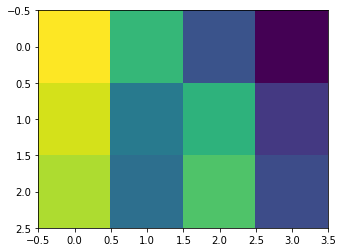

S2s


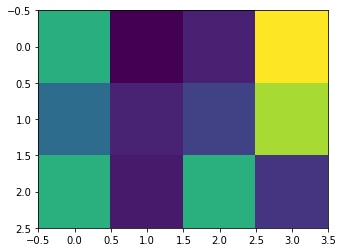

Us


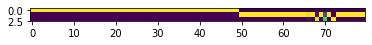

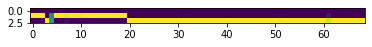

In [87]:
model.show_G_S_U()

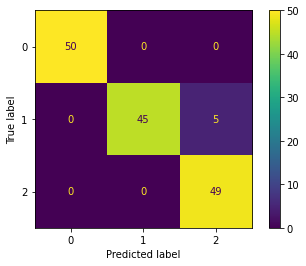

In [88]:
y_predict = pipeline.predict(X_clean) #(2000) <= (2000, 200)
cm = confusion_matrix(y_clean, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()